Imports

In [83]:
__author__ = "Artur Fejklowicz"

# Sources:
# - https://medium.com/@ashins1997/text-classification-dfe370bf7044
# - https://www.kaggle.com/code/shahkan/text-classification-using-logistic-regression
# - https://www.kaggle.com/code/satishgunjal/multiclass-logistic-regression-using-sklearn
# - https://medium.com/@cmukesh8688/tf-idf-vectorizer-scikit-learn-dbc0244a911a
# - https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from google.cloud import bigquery
import matplotlib.pyplot as plt
import nltk.stem.snowball
from sklearn.metrics import ConfusionMatrixDisplay
import nltk
from nltk.corpus import stopwords
#import seaborn as sns
import urllib.request



Retrive data from BigQuery

In [86]:
client = bigquery.Client(project="af-finanzen")
query = ("""SELECT
  description
  -- , Konto
  , CASE 
      WHEN Konto in ("PK Auto", "PK Maja", "PK Rest", "SK Haushalt", "Top-Up") THEN "Others"
      ELSE Konto
    END as Konto
FROM banks.revolut_mapping_internal
""")
df = client.query(query).to_dataframe()  # API request


## Data analysis

Basic

Konto
Others        66
PK Artur      75
PK Leben     105
PK Reisen     70
SK Ferien     86
Name: Konto, dtype: int64


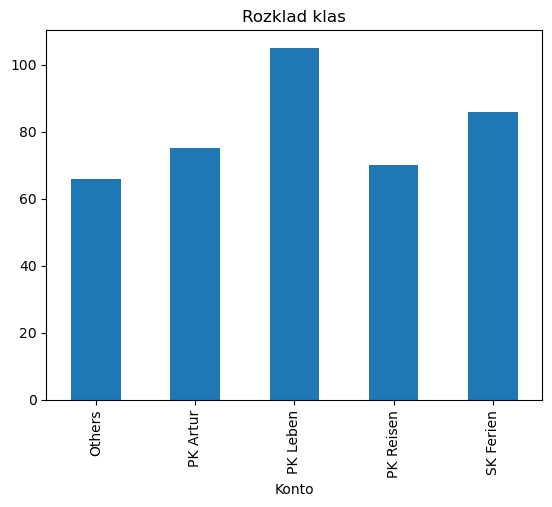

,description,Konto
0,Gama-M,Others
1,M P Majorca Pearls,SK Ferien
2,MGM. Pakowanie prezentów,PK Artur
3,Fikołki,Others
4,Google Bubadu,PK Artur
5,Funidelia,PK Artur
6,Mini Melts Spolka Z O.o,Others
7,Crazy Sowka Brozek And Tr,Others
8,Sala Zabaw Fikolki G 01,Others
9,Smyk,Others


In [ ]:
print(df.groupby("Konto").Konto.count())
df.groupby("Konto").Konto.count().plot(kind="bar", ylim=0, )
plt.title("Rozklad klas")
plt.show()

# df["Konto"].astype("category").cat.codes.plot(kind="hist", color="green", width=0.8)
# plt.show()
# df.info()

pd.concat( [df.head(10), df.tail(10)] )

Histogram of words

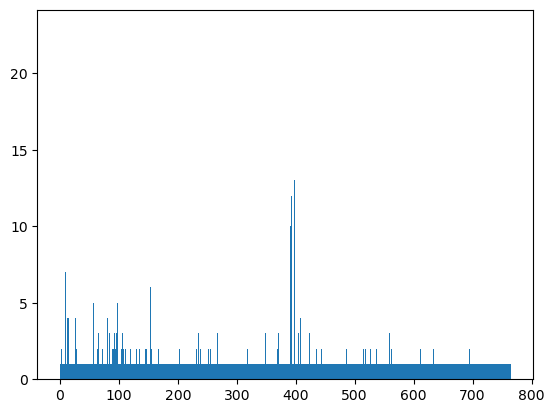

996 766


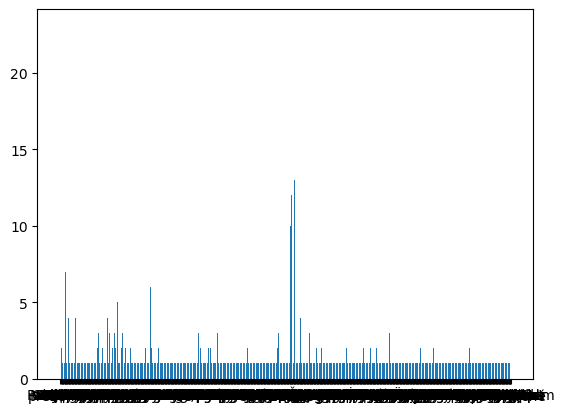

description    23
Konto          23
dtype: int64

In [122]:
hist_words_mapping = {}
hist_words = []

for document in df.description.to_list():
    words = document.split(" ")
    for word in words:
        if word not in hist_words_mapping.keys():
            hist_words_mapping[word] = len(hist_words_mapping)

    hist_words = hist_words + list(map(lambda w: hist_words_mapping[w], words))

plt.hist(hist_words, width=1, bins=766)
plt.show()

print(len(hist_words), len(hist_words_mapping))


words = [line.split() for line in df.description]
from collections import Counter
from itertools import chain
counter = Counter(chain.from_iterable(words))
#print(counter)

author_names = counter.keys()
author_counts = counter.values()

indexes = np.arange(len(author_names))
width = 0.7
plt.bar(indexes, author_counts, width)
plt.xticks(indexes + width * 0.5, author_names)
plt.show()

df[df.description.str.contains("Manual")].count()


Seaborn

In [ ]:
# sns.set_theme()
# #df.groupby("Konto").Konto.count()
# sns.countplot(data=df, x="Konto")

Stopwords

In [ ]:
stops_eng = set(stopwords.words('english'))
stops_ger = set(stopwords.words('german'))
stops_ita = set(stopwords.words('italian'))
stops_spa = set(stopwords.words('spanish'))
stops_fra = set(stopwords.words('french'))
# stops_pol = set(load_lines_from_file("../../python/logistic_regression_classification/polish.txt"))
link = "https://raw.githubusercontent.com/bieli/stopwords/master/polish.stopwords.txt"
lines=[]
responce = urllib.request.urlopen(link)
stops_pol = responce.read().decode().split(f"\n")

stops = list(stops_eng.union(stops_ger).union(stops_ita).union(stops_spa).union(stops_fra).union(stops_pol))
# if stops_pol:
#     stops = stops.union(stops_pol)
# stops = list(stops)

# stops=[]



Vectorization

In [ ]:
vectorizer = TfidfVectorizer(
    #min_df=0.0001,
    stop_words=stops,
    #max_features=1000,
    sublinear_tf=True, 
    #norm='l2', 
    ngram_range=(1, 1))
final_features = vectorizer.fit_transform(df['description']).toarray()
print(f"final_features.shape:\n{final_features.shape}")
#np.set_printoptions(threshold=np.inf)
#print(f"final_featurese:\n{final_features}")
# print(f"vectorizer.get_feature_names_out() {vectorizer.get_feature_names_out()}")


final_features.shape:
(402, 683)


Train Test Split

In [ ]:
X = df['description']
Y = df['Konto']
# print(f"Y {Y}")

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25)


Build and train model

In [ ]:


pipeline = Pipeline([('vect', vectorizer),
                     #('chi',  SelectKBest(chi2, k="all")),
                     ('clf',  LogisticRegression(multi_class='ovr', solver='liblinear', random_state=0))])


model = pipeline.fit(X_train, y_train)


Test and print report

In [ ]:
ytest = np.array(y_test)

#c_names = pipeline.feature_names_in_
#print(f"c_names: {c_names}")
#print(f"get_feature_names_out: {model.feature_names_in_}")

classification_report = classification_report(ytest, model.predict(X_test))

print(classification_report)

              precision    recall  f1-score   support

      Others       0.62      0.28      0.38        18
    PK Artur       0.80      0.20      0.32        20
    PK Leben       0.27      0.95      0.42        22
   PK Reisen       1.00      0.25      0.40        20
   SK Ferien       1.00      0.29      0.44        21

    accuracy                           0.41       101
   macro avg       0.74      0.39      0.39       101
weighted avg       0.74      0.41      0.40       101



Confusion Matrix Training Data

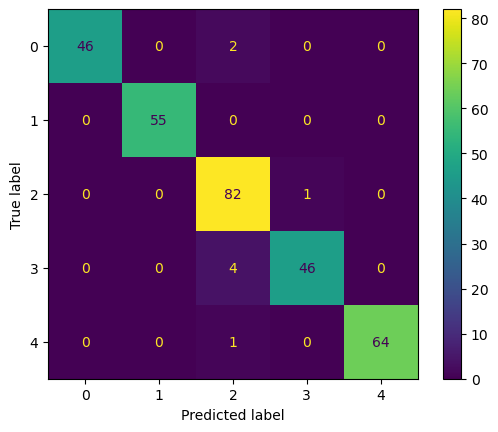

In [ ]:
confusion_matrix_training = confusion_matrix(np.array(y_train), model.predict(X_train))
# print(confusion_matrix_training)
# disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_training, display_labels=n_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_training)
disp.plot()
plt.show()

Confusion Matrix Testing Data

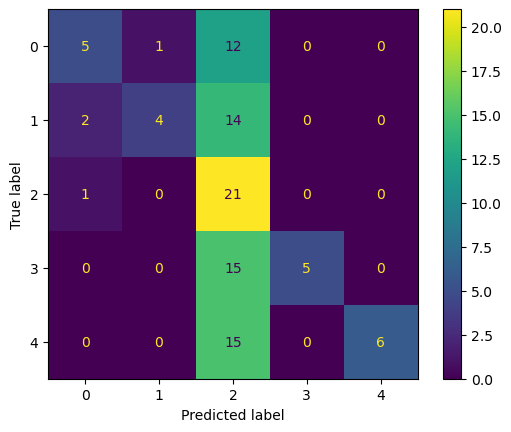

In [ ]:
confusion_matrix_testing = confusion_matrix(ytest, model.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_testing)
disp.plot()
plt.show()